# FNN from Scratch using only NumPy

the neural network algorithm by creating the model from scratch only with NumPy. You will learn how forward/backpropagation and weight normalization/activation of the simple single-layer neural network work. At the same time, we will continue to practice NumPy. This time we will use the famous MNIST dataset, and you will need to compare the result under different normalization/activation settings of the same architecture.

## 1. Data preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

The MNIST dataset was constructed from two datasets of the US National Institute
of Standards and Technology (NIST). The training dataset consists of handwritten
digits from 250 different people, 50 percent high school students and 50 percent
employees from the Census Bureau. Note that the test dataset contains handwritten digits from different people following the same split.

![alt text](https://dezyre.gumlet.net/images/Exploring+MNIST+Dataset+using+PyTorch+to+Train+an+MLP/MNIST+Dataset.png?w=900&dpr=1.0)

This MNIST dataset can be directly downloaded using scikit-learn.

In [2]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

It has 70,000 different handwriting instances. It usually has 60,000 instances as a training set and the remaining ones as a test set, but scikit-learn loads it as a whole. So we may need to divide it into two sets ourselves.

In [3]:
X.shape

(70000, 784)

In [4]:
X.shape, y.shape

((70000, 784), (70000,))

We can also check the class distribution - Last time, we dealt with imbalanced data.

<BarContainer object of 10 artists>

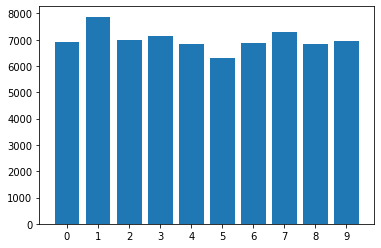

In [5]:
plt.bar(np.unique(y, return_counts = True)[0], np.unique(y, return_counts = True)[1])

You may also need to apply normalization for better performance. Since it is clear that its maximum value is 255, we can simply normalize it by dividing the whole value by 255. You can use NumPy's broadcasting to divide the matrix by one scalar value. It is also possible to further standardize it to have a centeralized mean, but it's optional. 
- Apply normalization to X to have the range [0, 1]

In [6]:
X_normalized = X / 255.0   # CHANGE IT

If you take a look at `y`, it has string labels! It might be disturbing when we need to handle them later, so let's also convert them to an integer form.

In [7]:
y_integer = y.astype(int) # CHANGE IT

Those will be our simple preprocessing modules! Next we will split the dataset into two parts using scikit-learn's `train_test_split` method.
- Use scikit-learn's `train_test_split` to create training and test sets.
- Set **train_size** = 60,000 **test_size** = 10,000.
- Enable stratification.
- use `X_normalized` and `y_integer`.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_integer, test_size=0.142857,stratify=y)    # CHANGE IT

Here you can check some of the instances that we have.

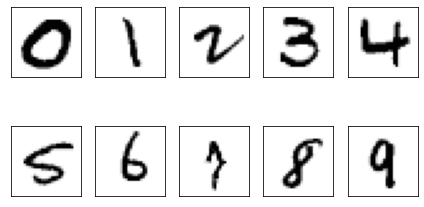

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
  img = X_train[y_train == i][0].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## 2. Helper functions

We will develop it with a class representation to use scikit-learn's pipeline. This means we might need to develop `fit` and `transform` methods inside the class. Before creating the class structure, let's create some helper functions.

First, we need to fix the labels, which are now in a sparse form, to have a one-hot encoded form for better computation using NumPy's vectorization. Let's create a function that receives a label vector and transform it into a one-hot encoded label matrix.

- Complete the `one_hot` function.

In [10]:
def one_hot(y):
  """
  Input:
    - y : set of labels

  Output:
    - onehot: a one-hot-encoded array

  This function creates an one-hot encoded representation of the labels.
  This means that you will have a set of binary columns indicading each possible class.

  You have to develop this one hot encoding strategy without using Python for loop 
  """
  m = y.shape[0]
  n = np.unique(y).shape[0] 
  out = np.zeros((m, n))
  out[np.arange(m), y] = 1

  return out      # CHANGE IT


The expected outcome of the one-hot encoding is as follows:

In [11]:
one_hot(np.array([1,0,2,3]))

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

Next we may also need a sigmoid function for the output values as we are dealing with a classification problem. Sigmoid can be represented as follows:

$$ h_ \theta (x) =  \frac{\mathrm{1} }{\mathrm{1} + e^{-x} }  $$ 


- Complete the sigmoid function below that supports both vectors and scalars.

In [12]:
def sigmoid(x):
  """
  Input:
    - z: input vector or scalar value

  Output:
    - sigmoid: output sigmoid-transformed vector or scalar value

  Calculate the sigmoid value of the input.
  """
  # x = np.clip(x, -250, 250)
  np.seterr( over='ignore' )    #added to ignore the overflow error due to the value of x
  out = 1 / (1 + np.exp(-x))

  return  out    # CHANGE IT

The expected result of the sigmoid function is as follows:

In [13]:
sigmoid(np.array([np.inf, -np.inf, 0]))

array([1. , 0. , 0.5])

## 3. Our FCN classifier with the class structure

Now it's time to create our neural network model from scratch! We will eventually integrate everything into scikit-learn's pipeline, so it's important to have an appropriate class structure. To do this, you may need to extend `BaseEstimator` and `TransformerMixin` to make scikit-learn recognize that our class is a valid classifier.

We are going to develop a neural network with one layer for simplicity. That means we will have two different sets of weights.

- First layer: [input size (number of features), hidden layer size]
- Second layer: [hidden layer size, output size (number of classes)]

In our class structure `FullyConnectedNetwork`, we will develop five different methods as follows:
 - `compile`: Given parameters, we will initialize weight and bias values needed for our neural network model.
   - Here, you will initialize bias and weights based on chosen initialization technique.
        - We will have three different options: normal, Xavier, and he
        - Each technique initializes the weight using the normal distribution but different standard deviation.
          - Normal: 
$ \mu = 0, \sigma = 0.1 $
          - Xavier: 
$ \mu = 0, \sigma = \sqrt{\frac{2}{n_{in} + n_{out}}}$
          - He:
$ \mu = 0, \sigma = \sqrt{\frac{2}{n_{in}}}$
 - `forward`: Perform a forward propagation
 - `back_propagation`: Perform a back propagation
    - You will only need to finish some part of it.
      - Weight and bias update
      - Derivative of the sigmoid function
        - $σ(x)=σ(x)(1−σ(x))$.

 - `fit`: Run the whole fitting process (forward and backpropagation for each batch)
 - `cost`: Calculate the cost (cross-entropy) together with the elastic net (l1/l2)
   - cross-entropy loss can be calculated as follows:
 - `predict`: With a trained model, perform a prediction of unseen data by running the forward propagation with the trained weight and bias.
 - `evaluate`: With trained weight and bias, perform a prediction of test data and calculate the performance metric (in our case, those are training and validation accuracy scores).

**This exercise is based on Chapter 12 of the coursebook Python Machine Learning with some modification and additional tasks - so please note that the structure and requirements are not the same.**

**You are free to check out the coursebook for reference. However, to solve the tasks, you should understand the logic clearly.**

In [14]:
class FullyConnectedNetwork(BaseEstimator, TransformerMixin):
    def __init__(self, n_hidden=30, l2=0., l1=0., epochs=100, eta=0.001, validation_rate = 0.3,
                 shuffle=True, batch_size=1, init_technique = "normal", seed=None, debug=True):

        """
        We receive the following parameters to construct and test the model:

        Input:
          - n_hidden: Number of hidden nodes.
          - l2: Lambda value for L2-regularization.
          - epochs: Number of passes over the training set.
          - eta: Learning rate.
          - shuffle: Enabling shuffling option of the dataset every epoch.
          - batch_size: Number of training examples per batch.
          - seed: Random seed for initializing weights and shuffling.
        """
        self.seed = seed
        self.random = np.random.RandomState(self.seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.l1 = l1
        self.epochs = epochs
        self.eta = eta
        self.validation_rate = validation_rate
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.debug = debug
        self.init_technique = init_technique

    def compile(self, n_features, n_outputs):
        """
        Initializing the weights of the model

        - Here you will initialize bias and weights based on chosen initialization technique.
        - We will have three different options: normal, xavier, and he
        - Each technique initializes the weight using the normal distribution but different standard deviation.
        - Use self.init_technique to check the chosen technique and use self.random to perform the sampling.

        Input:
          - n_features: input size of the network
          - n_outputs: output size of the network
          - Unit size of the layer is given as self.n_hidden

        Steps:
          1. Create lists self.W and self.B.
          2. Set mean and standard deviation for different initialization technique.
          3. Create weights and bias for the linkage between inputs and the a layer.
            - Weight should have the size [n_features, self.n_hidden].
            - Bias should have the size [self.n_hidden].
            - Weight initialization should be applied to the weights only.
            - Bias should be initizalied by zeros.
          4. Create weights and bias for the linkage between layer and outputs.
            - Weight should have the size [self.n_hidden, n_outputs].
            - Bias should have the size [n_outputs].
            - Weight initialization should be applied to the weights only.
            - Bias should be initizalied by zeros.
          5. Save the weights to self.W and biases to self.B.

        """

        self.B = []
        self.W = []

        if (self.init_technique == 'normal'):
          mean = 0.0
          std = 0.1
        elif(self.init_technique == 'xavier'):
          mean = 0.0
          std = np.sqrt(2 / (n_features + n_outputs))
        elif(self.init_technique == 'he'):
          mean = 0.0
          std = np.sqrt(2 / n_features)
        

        # 1. Creating weights and bias for input -> hidden
        # Use specific initialization techniques for weights
        # Weights should have the size (n_features, self.n_hidden)
        # Use np.zeros for bias with the size 'self.n_hidden'

        b_h = np.zeros(self.n_hidden)       # CHANGE IT
        w_h = np.random.normal(loc=mean, scale=std, size=(n_features, self.n_hidden))      # CHANGE IT

        # 2. Append bias to self.B and weights to self.W
        self.B.append(b_h)
        self.W.append(w_h)

        # 3. Creating weights and bias for hidden -> output
        # Use specific initialization techniques for weights
        # Weights should have the size (self.n_hidden, n_outputs)
        # Use np.zeros for bias with the size 'n_outputs'

        b_out = np.zeros(n_outputs)                                             # CHANGE IT
        w_out = np.random.normal(loc=mean, scale=std, size=(self.n_hidden, n_outputs))      # CHANGE IT

        # 4. Append bias to self.B and weights to self.W
        self.B.append(b_out)
        self.W.append(w_out)


    def forward(self, X):
        """
        Given the dataset X, compute forward propagation step with the weights and bias saved in the list.
        This process eventually outputs ten numbers in our case as we have ten outputs.
        Forward propagation is performed by multiple chained dot products of inputs and weights.
        
        Input:
          - X: features
        
        Output:
          - Z: Result of dot product of the weights and the previous output for each phase
          - A: A list that contains sigmoided values of A
        Steps:
          1. Create two lists Z and A.
          2. Take a dot product of X and the first weight self.W[0] - save the result into Z
          3. Apply sigmoid function to the first Z - save the result into A
          4. Take a dot product of A and the second weight self.W[1] - save the result into Z
          5. Return Z and A
        """

        Z = []
        A = []

        # Step 1: net input of hidden layer
        # - take a dot product of the input features and the initial weights
        # - add the outcome to list Z
        s_h = np.dot(X,self.W[0]) + self.B[0]
        Z.append(s_h)       # CHANGE IT

        # Step 2: activation of hidden layer
        # - apply the sigmoid function to the dot producted outcome
        # - add the outcome to list A
        sig_h = sigmoid(Z[0])
        A.append(sig_h)       # CHANGE IT

        # Step 3: net input of output layer
        # - take a dot product of the intermediate features and the weights of the output layer
        # - add the outcome to list Z
        s_o = np.dot(A[0],self.W[1]) + self.B[1]
        Z.append(s_o)         # CHANGE IT

        # Step 4: activation output layer
        # - apply the sigmoid function to the dot producted outcome
        # - add the outcome to list A
        sig_o = sigmoid(Z[1])
        A.append(sig_o)       # CHANGE IT

        return Z, A

    def predict(self, X):
        """
        
        Predict class labels by performing forward propagation.

        Input: 
          - X: feature matrix
        Output:
          - y_pred: Predicted class labels for all data instances.

        Steps:
          1. Run forward proparation on X and get Z, a.
          2. Calculate y_pred by using the output (A[-1]) and with np.argmax
            - You have to choose the index of the one with the highest value
          3. Return the prediction. You can perform the operation once if you use NumPy's vectorization feature.

        """

        Z, A = self.forward(X)
        y_pred = np.argmax(A[-1],axis=1)

        return y_pred    # CHANGE IT

    def cost(self, y_truth, y_pred):
        """
        
        This function computes the cost for the classification task.
        We will also apply Elastic net (combination of l1 and l2)

        Input:
          - y_truth: "one-hot encoded" class labels.
          - y_pred: Activation of the output layer (= output of the forward propagation function)
          - the weights for l1 and l2 are saved into self.l1 and self.l2
        
        Output:
          - cost: Regularized cost

        Steps:
          1. Calculate the cross entropy between the truth and predicted values.
          2. Add l1 and l2 terms to the cost.
            - L1 term is the sum of absolute weight values
            - L2 term is the sum of squared weight values
            - You should multiply l1 and l2 ratio saved in self.l1 and self.l2
            - You should NOT include weights that belong to the bias values.
          3. Return the total cost (cross entropy + L1 term + L2 term).

        """

        # y_truth = np.array(y_truth)
        # y_pred = np.array(y_pred)
        y_truth_enc = one_hot(y_truth)
        y_pred_enc = one_hot(y_pred)

        w_h = self.W[0][1:]
        w_out = self.W[1][1:]
        
        # term1 = -y_truth * (np.log(y_pred + 1e-5))
        # term2 = (1 - y_truth) * np.log(1 - y_pred + 1e-5)
        # cross_entropy = np.sum(term1 - term2)
        cross_entropy = -np.sum(y_truth_enc * np.log(y_pred_enc + 1e-5))
        l1_term = (self.l1 * (np.sum(np.abs(w_h)) + np.sum(np.abs(w_out))))
        l2_term = (self.l2 * (np.sum(np.square(w_h)) + np.sum(np.square(w_out))))

        cost = cross_entropy + l1_term + l2_term      # CHANGE IT
        
        return cost

    

    def back_propagation(self, X_train, batch_idx, A, y_truth):
      """
      Perform back propagation based on the result of forward propagation and true labels (for each batch).

      Input:
        X_train: training features
        batch_idx: the current batch indices from the fit function
        A: Sigmoided output values - the result of forward propagation
        y_truth: One-hot encoded true labels

      Output:
        None
        You should update the weights and biases in self.W/self.B

      **** You only need to fill in some required parts marked as "CHANGE THIS PART" ****
      **** To get more information about the backpropagation process: 
           https://towardsdatascience.com/deriving-backpropagation-with-cross-entropy-loss-d24811edeaf9 ****
      """

      # OUTPUT WEIGHTS (LAYER-OUTPUT)

      # δC/δA * δA/δZ
      delta_out = A[-1] - y_truth[batch_idx]   
      # δC/δA * δA/δZ * δZ/δW
      grad_w_out = np.dot(A[0].T, delta_out)
      # δC/δA * δA/δZ * δZ/δB
      grad_b_out = np.sum(delta_out, axis=0)

      #############################################
      # CHANGE THIS PART
    
      # Using the final gradients of the weight and bias (grad_w_out, grad_b_out), we need to update
      # Change the values of self.W[1], self.B[1] (output weight and bias).
      # - You should also apply l1 and l2 normalization to the weight (not to the bias)
      # - You should use the learning rate (self.eta) when changing the value.

      l1_w = self.l1 * self.W[1]
      l2_w = self.l2 * self.W[1]
    
      delta_w_out = (grad_w_out + (l1_w + l2_w))                          # CHANGE IT
      delta_b_out = grad_b_out                                            # CHANGE IT
      self.W[1] -= self.eta * delta_w_out                                 # CHANGE IT
      self.B[1] -= self.eta * delta_b_out                                 # CHANGE IT

      # END OF CHANGE
      #############################################
      
      # HIDDEN WEIGHTS (INPUT-LAYER)

      #############################################
      # CHANGE THIS PART

      # To continue to take derivatives backwards, we need to be able to take a derivative of the sigmoid function.
      # Here we are trying to take derivative of a sigmoided output A[0].
      # Derivative of sigmoid σ(x) can be represented as σ(x)(1−σ(x)).
      
      sigmoid_derivative_h = (A[0]) * (1 - A[0])                # CHANGE IT

      # END OF CHANGE
      #############################################

      delta_h = (np.dot(delta_out, self.W[1].T) * sigmoid_derivative_h)
      grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
      grad_b_h = np.sum(delta_h, axis=0)

      #############################################
      # CHANGE THIS PART

      # Using the final gradients of the weight and bias (grad_w_h, grad_b_h), we need to update
      # Change the values of self.W[0], self.B[0] (output weight and bias).
      # - You should also apply l1 and l2 normalization to the weight (not to the bias)
      # - You should use the learning rate (self.eta) when changing the value.

      # delta_w_h = self.eta * (grad_w_h + (l1_l2 * self.W[0,1:]))       # CHANGE IT
      l1_w0 = self.l1 * self.W[0]
      l2_w0 = self.l2 * self.W[0]

      delta_w_h = (grad_w_h + (l1_w0 + l2_w0))                           # CHANGE IT
      delta_b_h = grad_b_h                                               # CHANGE IT
      
      self.W[0] -= self.eta * delta_w_h                                  # CHANGE IT
      self.B[0] -= self.eta * delta_b_h                                  # CHANGE IT

      # END OF CHANGE
      #############################################

    
    def evaluate(self, epoch, X_train, X_valid, y_train, y_valid):
      """
      Evaluate performances on the training and validation sets per epoch
      
      Input:
        - epoch: current epoch number
        - X_train: training features
        - X_valid: validation features
        - y_train: training labels
        - y_valid: validation labels

      Output:
        - None
        Append the cost and performance metrics of current epoch to self.history
      """

      # Step 1. Call self.forward on X_train to calculate the output with current weights and bias of the model
      Z, A = self.forward(X_train)      # CHANGE IT

      # Step 2. call predict functions with both X_train and X_valid and save the predicted values accordingly
      y_train_pred = self.predict(X_train)      # CHANGE IT
      y_valid_pred = self.predict(X_valid)      # CHANGE IT
      

      # Step 2. Call self.cost with y_train and y_train_pred
      # save it into the variable 'cost'
      cost = self.cost(y_train,y_train_pred)      # CHANGE IT

      # Step 4. Calculate accuracy scores 
      # - between y_train_pred and y_train
      # - between y_valid_pred and y_valid

      train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])       # CHANGE IT
      valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) / X_valid.shape[0])       # CHANGE IT

      # Step 5. Save the results into the dictionary
      # This part is already complete
      if self.debug == True:
        print('%d/%d | Cost: %.2f '
                        '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                        (epoch+1, self.epochs, cost,
                          train_acc*100, valid_acc*100))

      self.history['cost'].append(cost)
      self.history['train_acc'].append(train_acc)
      self.history['valid_acc'].append(valid_acc)

    
    def fit(self, X, y):
        """ 
        
        Learn weights from training data.

        Input
          - X: features (training+validation)
          - y: labels

        Output
          - self.history: information about cost and accuracy scores

        """

        self.history = {'cost': [], 'train_acc': [], 'valid_acc': []}

        # Step 1: Select different training and test sets. Use scikit-learn's train_test_split.
        # Turn on the stratification option and use self.validation_rate
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=self.validation_rate, random_state=self.random, stratify=y)  # CHANGE IT

        # Step 2: Compile (initialize) the parameters by running self.compile with correct number of features and outputs
        # WRITE YOUR CODE HERE

        n_output = np.unique(y_train).shape[0]
        n_feature = X_train.shape[1]
        self.compile(n_features=n_feature, n_outputs=n_output)   
        
        #

        # Step 3: Prepare one-hot encoded training labels by using one_hot function on y_train
        y_train_enc = one_hot(y_train)        # CHANGE IT
        

        # Step 4: iterate over training epochs
        for i in range(self.epochs):

            # Step 5: set the indices
            # - if self.shuffle is True, shuffle the indices using self.random.shuffle or permutation
            indices = np.arange(X_train.shape[0])      # CHANGE IT
            if(self.shuffle == True):
              self.random.shuffle(indices)

            # Step 6: iterate over the data
            # - For each iteration, you need to choose the data 
            for start_idx in range(0, indices.shape[0] - self.batch_size +
                                   1, self.batch_size):
                batch_idx = indices[start_idx:start_idx + self.batch_size]       # CHANGE IT

                # Step 7: Run a forward propagation
                Z, A = self.forward(X_train[batch_idx])       # CHANGE IT

                # Step 8: Run back propagation 
                # - Use X_train, batch_idx, A, and y_train_enc
                # WRITE YOUR CODE HERE
                self.back_propagation(X_train, batch_idx, A, y_train_enc)
                #


            # call evaluate function after inner loop (whole batch cycles) is complete
            # WRITE YOUR CODE HERE
            
            self.evaluate(i, X_train, X_valid, y_train, y_valid)

            #

        # Step 9: After all loops are complete, return self.history
        return self.history

    def transform(self, X, y=None):
      """
      We do not need to complete this function.
      Leave as it is!
      """
      return self.history
    
    def score(self, X, y=None):
      """
      Score function for pipeline
      Leave as it is!
      """
      y_pred = self.predict(X)
      acc = np.sum(y == y_pred) / X.shape[0]
      return acc

After you finish developing the methods in the class structure, you can create a new instance as follows:

In [15]:
nn = FullyConnectedNetwork(n_hidden=100, l2=0.01, epochs=100, eta=0.0005, batch_size=100, shuffle=True, seed=12345)

We will try to run 100 epochs, and depending on your computing power, it might take a few minutes to an hour.
 - Train your network on `X_train` and `y_train` and save the output to `history`.

In [16]:
history = nn.fit(X_train, y_train)

C:\Users\deept\AppData\Local\Temp/ipykernel_8476/973144741.py:337: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])       # CHANGE IT
C:\Users\deept\AppData\Local\Temp/ipykernel_8476/973144741.py:338: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  valid_acc = 

1/100 | Cost: 99306.94 | Train/Valid Acc.: 79.46%/79.22% 
2/100 | Cost: 73622.05 | Train/Valid Acc.: 84.78%/84.75% 
3/100 | Cost: 64204.83 | Train/Valid Acc.: 86.72%/86.69% 
4/100 | Cost: 57124.67 | Train/Valid Acc.: 88.19%/88.08% 
5/100 | Cost: 53590.45 | Train/Valid Acc.: 88.92%/88.88% 
6/100 | Cost: 50689.41 | Train/Valid Acc.: 89.52%/89.43% 
7/100 | Cost: 49100.82 | Train/Valid Acc.: 89.85%/89.93% 
8/100 | Cost: 47374.05 | Train/Valid Acc.: 90.20%/90.28% 
9/100 | Cost: 45877.52 | Train/Valid Acc.: 90.51%/90.56% 
10/100 | Cost: 44553.68 | Train/Valid Acc.: 90.79%/90.83% 
11/100 | Cost: 43690.34 | Train/Valid Acc.: 90.97%/90.93% 
12/100 | Cost: 42585.23 | Train/Valid Acc.: 91.20%/91.16% 
13/100 | Cost: 41238.33 | Train/Valid Acc.: 91.47%/91.51% 
14/100 | Cost: 40490.11 | Train/Valid Acc.: 91.63%/91.56% 
15/100 | Cost: 39396.49 | Train/Valid Acc.: 91.85%/91.89% 
16/100 | Cost: 38590.69 | Train/Valid Acc.: 92.02%/91.93% 
17/100 | Cost: 37980.61 | Train/Valid Acc.: 92.15%/91.96% 
18/100

After the training is done, you should be able to plot the training and validation accuracy scores over time using the `history` dictionary returned by the fit function.

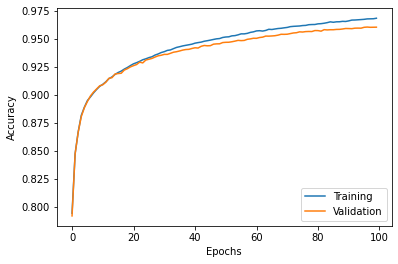

In [17]:
plt.plot(history['train_acc'],label='Training')
plt.plot(history['valid_acc'],label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

## 4. Integrate our classifier into the scikit-learn pipeline and the randomized search

This time, we will use the same strategy as the second lab, trying to integrate everything from the raw dataset to the performance metrics into scikit-learn pipeline. 

- Task 1: Create a `Normalizer` class that extends BaseEstimator and TransformerMixin.
 - Your normalizer should do the following job:
   - Normalizer: To make the features have the range [0, 1] and also **center the points to zero by subtracting 0.5 from the values.**
   - Use NumPy's broadcasting to calculate (X / 255) - 0.5.


- Task 2: Create a pipeline that integrates both normalizer and your neural network classifier.
  - Your pipeline should contain the following modules.
    - 'normalizer': Normalizer class
    - 'classifier': `FullyConnectedNetwork` with default parameters but with epochs=10.

- Task 3: Fit your pipeline on the datasets (`X_train`, `y_train`).
  - You should **not** use `X_normalized` this time as the normalizer is now part of your pipeline. This means you might need to split your dataset again with `train_test_split` by using `X` and `y_integer`. Turn on stratification, and set `train_size` = 60000, `test_size` = 10000.
  - Fit your pipeline and report the test score on `X_test` and `y_test` to `pipeline_score`.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y_integer, test_size=0.142857,stratify=y) 

In [19]:
# Create: class Normalizer(BaseEstimator, TransformerMixin)
#
#
class Normalizer(BaseEstimator, TransformerMixin):
  """
  Normalizer: To make the features have the range [0, 1] and also center the points to zero by subtracting 0.5 from the values.
   - Use NumPy's broadcasting to calculate (X / 255) - 0.5.
  """
  def __init__(self):
    return None
  
  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None):
    X = np.array((X / 255) - 0.5)
    return X


# Creating a pipeline
# - scaler = Normalizer()
# - classifier = FullyConnectedNetwork

pipe = Pipeline([
  ('normalizer', Normalizer()),
  ('classifier', FullyConnectedNetwork(n_hidden=30, l2=0, l1=0, epochs=10, eta=0.001, validation_rate=0.3, shuffle=True, batch_size=1, init_technique="normal", seed=None, debug=True))
])

pipe.fit(X_train, y_train)


C:\Users\deept\AppData\Local\Temp/ipykernel_8476/973144741.py:337: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])       # CHANGE IT
C:\Users\deept\AppData\Local\Temp/ipykernel_8476/973144741.py:338: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  valid_acc = 

1/10 | Cost: 107104.42 | Train/Valid Acc.: 77.85%/77.59% 
2/10 | Cost: 70447.23 | Train/Valid Acc.: 85.43%/85.01% 
3/10 | Cost: 56194.22 | Train/Valid Acc.: 88.38%/87.88% 
4/10 | Cost: 49723.95 | Train/Valid Acc.: 89.72%/89.24% 
5/10 | Cost: 47052.95 | Train/Valid Acc.: 90.27%/89.69% 
6/10 | Cost: 44784.90 | Train/Valid Acc.: 90.74%/90.09% 
7/10 | Cost: 43023.42 | Train/Valid Acc.: 91.10%/90.49% 
8/10 | Cost: 41400.10 | Train/Valid Acc.: 91.44%/90.73% 
9/10 | Cost: 39903.41 | Train/Valid Acc.: 91.75%/91.03% 
10/10 | Cost: 38452.78 | Train/Valid Acc.: 92.05%/91.36% 


Pipeline(steps=[('normalizer', Normalizer()),
                ('classifier', FullyConnectedNetwork(epochs=10, l1=0, l2=0))])

In [20]:
# REPORT YOUR SCORE HERE
training_score = str(pipe.score(X_train, y_train))
pipeline_score = str(pipe.score(X_test, y_test))        # CHANGE IT
print(pipeline_score)

0.9166


- Task 4: Randomized search
  - After constructing your pipeline, we will perform a randomized search on it.
  - Define your parameter grid with the following information:
    - l1 of classifier: [0.001, 0.01, 0.1]
    - l2 of classifier: [0.001, 0.01, 0.1]
    - size of hidden layer of classifier: [30, 50, 100]
    - learning rate of classifier: [0.0001, 0.0005, 0.001]
    - initialization techniques of classifier: [normal, xavier, he]
  - Run your randomized search with cv=3. Fit it on your previous `X_train` and `y_train`. 
    - Make 10 different attempts.
    - Set `random_state` = 12345
  - Report your best classifier and best score into the variables `best_classifier` and `best_score`.

  - **Note that this task will take a few hours based on computing power, so you may not need to finish the run. We will only check if the logic is correct if you cannot finish the task before the submission.**

In [21]:
pipe.get_params().keys() 

dict_keys(['memory', 'steps', 'verbose', 'normalizer', 'classifier', 'classifier__batch_size', 'classifier__debug', 'classifier__epochs', 'classifier__eta', 'classifier__init_technique', 'classifier__l1', 'classifier__l2', 'classifier__n_hidden', 'classifier__seed', 'classifier__shuffle', 'classifier__validation_rate'])

In [22]:

l1_values = [0.001,0.01,0.1]
l2_values = [0.001,0.01,0.1]
n_hidden_values = [30,50,100]
eta_rates = [0.0001,0.0005,0.001]
init_technique_values = ['normal', 'xavier','he']

parameters = {'classifier__l1': l1_values,
               'classifier__l2': l2_values,
               'classifier__n_hidden': n_hidden_values,
               'classifier__eta': eta_rates,
               'classifier__init_technique': init_technique_values}                           # CHANGE IT



grid = RandomizedSearchCV(estimator = pipe, param_distributions = parameters, cv = 3, n_iter = 10, random_state=12345)          # CHANGE IT
grid.fit(X_train, y_train)

best_classifier = grid.best_estimator_          # CHANGE IT
best_score = grid.best_score_                   # CHANGE IT

print(best_classifier, best_score)

C:\Users\deept\AppData\Local\Temp/ipykernel_8476/973144741.py:337: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])       # CHANGE IT
C:\Users\deept\AppData\Local\Temp/ipykernel_8476/973144741.py:338: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  valid_acc = 

1/10 | Cost: 212238.27 | Train/Valid Acc.: 34.17%/34.32% 


C:\Users\deept\AppData\Local\Temp/ipykernel_8476/973144741.py:337: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])       # CHANGE IT
C:\Users\deept\AppData\Local\Temp/ipykernel_8476/973144741.py:338: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  valid_acc = 

1/10 | Cost: 83961.70 | Train/Valid Acc.: 73.96%/73.17% 
2/10 | Cost: 65246.50 | Train/Valid Acc.: 79.76%/79.12% 
3/10 | Cost: 52889.87 | Train/Valid Acc.: 83.60%/83.23% 
4/10 | Cost: 50816.05 | Train/Valid Acc.: 84.24%/83.79% 
5/10 | Cost: 46233.26 | Train/Valid Acc.: 85.66%/85.54% 
6/10 | Cost: 47453.40 | Train/Valid Acc.: 85.28%/84.85% 
7/10 | Cost: 46405.67 | Train/Valid Acc.: 85.61%/85.22% 
8/10 | Cost: 50815.14 | Train/Valid Acc.: 84.24%/83.99% 
9/10 | Cost: 45645.84 | Train/Valid Acc.: 85.84%/85.51% 
10/10 | Cost: 44713.32 | Train/Valid Acc.: 86.13%/85.98% 


C:\Users\deept\AppData\Local\Temp/ipykernel_8476/973144741.py:337: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])       # CHANGE IT
C:\Users\deept\AppData\Local\Temp/ipykernel_8476/973144741.py:338: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  valid_acc = 

1/10 | Cost: 87668.76 | Train/Valid Acc.: 72.81%/71.83% 
2/10 | Cost: 64509.58 | Train/Valid Acc.: 79.99%/79.11% 
3/10 | Cost: 59302.53 | Train/Valid Acc.: 81.61%/80.82% 
4/10 | Cost: 52496.92 | Train/Valid Acc.: 83.72%/82.93% 
5/10 | Cost: 47971.69 | Train/Valid Acc.: 85.12%/84.38% 
6/10 | Cost: 49675.38 | Train/Valid Acc.: 84.59%/83.85% 
7/10 | Cost: 48719.73 | Train/Valid Acc.: 84.89%/84.38% 
8/10 | Cost: 45968.15 | Train/Valid Acc.: 85.74%/84.95% 
9/10 | Cost: 44080.06 | Train/Valid Acc.: 86.33%/85.59% 
10/10 | Cost: 46808.63 | Train/Valid Acc.: 85.48%/84.63% 


C:\Users\deept\AppData\Local\Temp/ipykernel_8476/973144741.py:337: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])       # CHANGE IT
C:\Users\deept\AppData\Local\Temp/ipykernel_8476/973144741.py:338: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  valid_acc = 

1/10 | Cost: 79010.88 | Train/Valid Acc.: 75.50%/75.28% 
2/10 | Cost: 68734.75 | Train/Valid Acc.: 78.68%/78.13% 
3/10 | Cost: 56562.37 | Train/Valid Acc.: 82.46%/81.72% 
4/10 | Cost: 50459.04 | Train/Valid Acc.: 84.35%/83.83% 
5/10 | Cost: 47154.20 | Train/Valid Acc.: 85.38%/84.67% 
6/10 | Cost: 50492.71 | Train/Valid Acc.: 84.34%/83.90% 
7/10 | Cost: 45519.09 | Train/Valid Acc.: 85.88%/85.01% 
8/10 | Cost: 46624.32 | Train/Valid Acc.: 85.54%/84.81% 
9/10 | Cost: 47648.99 | Train/Valid Acc.: 85.22%/84.46% 
10/10 | Cost: 44828.35 | Train/Valid Acc.: 86.10%/85.52% 


C:\Users\deept\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
27 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\deept\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\deept\AppData\Roaming\Python\Python39\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\deept\AppData\Local\Temp/ipykernel_8476/973144741.py", line 414, in fit
    self.evaluate

1/10 | Cost: 117195.30 | Train/Valid Acc.: 75.77%/75.37% 
2/10 | Cost: 85977.79 | Train/Valid Acc.: 82.22%/81.87% 
3/10 | Cost: 82982.57 | Train/Valid Acc.: 82.84%/82.43% 
4/10 | Cost: 74646.75 | Train/Valid Acc.: 84.56%/84.19% 
5/10 | Cost: 70145.12 | Train/Valid Acc.: 85.50%/85.23% 
6/10 | Cost: 69822.80 | Train/Valid Acc.: 85.56%/85.58% 
7/10 | Cost: 69465.94 | Train/Valid Acc.: 85.64%/85.58% 
8/10 | Cost: 68533.41 | Train/Valid Acc.: 85.83%/85.82% 
9/10 | Cost: 71826.11 | Train/Valid Acc.: 85.15%/84.98% 
10/10 | Cost: 67232.47 | Train/Valid Acc.: 86.10%/85.99% 
Pipeline(steps=[('normalizer', Normalizer()),
                ('classifier',
                 FullyConnectedNetwork(epochs=10, l1=0.01, l2=0.01,
                                       n_hidden=50))]) 0.85635


# END